In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def sinc_weight(Nfft, Ntaps):
    L = Nfft*Ntaps
    x=np.pi*(np.arange(L)-L/2+0.5)/(Nfft)
    w = np.sin(x)/x  
    w[x==0.0]=1.0    
    return w


class PFB:
    def __init__ (self,Nfft=4096, Ntaps=4, Nnotch=16, window=None, dfilt=False):
        self. w=sinc_weight(Nfft,Ntaps) 
        if window is not None:
            self.w *= window(Nfft*Ntaps)
        self.wNotch = sinc_weight(Nnotch//4,4)*np.hamming(Nnotch)
        self.wNotch = self.wNotch/np.sum(self.wNotch)*np.sqrt(Nnotch)
        self.Ntaps=Ntaps
        self.Nfft=Nfft
        self.Nnotch=Nnotch
        self.Nchan = Nfft//2
        self.dfilt = dfilt

    def process_window (self,data):
        assert (len(data)==len(self.w)), "Data length must be Nfft*Ntaps"        
        if self.dfilt:
            xdata = data.reshape((32,512)).mean(axis=0)
            data = data - np.array(np.hstack([xdata]*32))
            print('here')
            
        d = data*self.w
        d = d.reshape(self.Ntaps,self.Nfft).sum(axis=0)
        assert(len(d)==self.Nfft)
        pfb = np.fft.rfft(d)
        return pfb[:-1]
    
    def get_pk (self, gen_function):
        pk = np.array([np.abs(self.process_window(gen_function()))**2 for i in range(1000)])
        return pk.mean(axis=0)





In [11]:
noise_level = 3.5  # in nV/sqrt(Hz)
## total rms 
noise_rms = np.sqrt((noise_level**2 * 51.2e6))
Atone = 3e6
V2ADC = 0.000813
Nfft = 4096
Ntaps = 4
Ntot = Ntaps*Nfft
tonendx = 10
BW = 51.2E6
binBW = BW / (Nfft/2)


def noise_wf():
    return np.random.standard_normal(Ntot)*noise_rms*V2ADC

def tone_wf():
    return Atone*V2ADC*np.cos(np.random.uniform(0,2*np.pi)+np.arange(Ntot)/Ntot*tonendx*2*np.pi*Ntaps)+noise_wf()

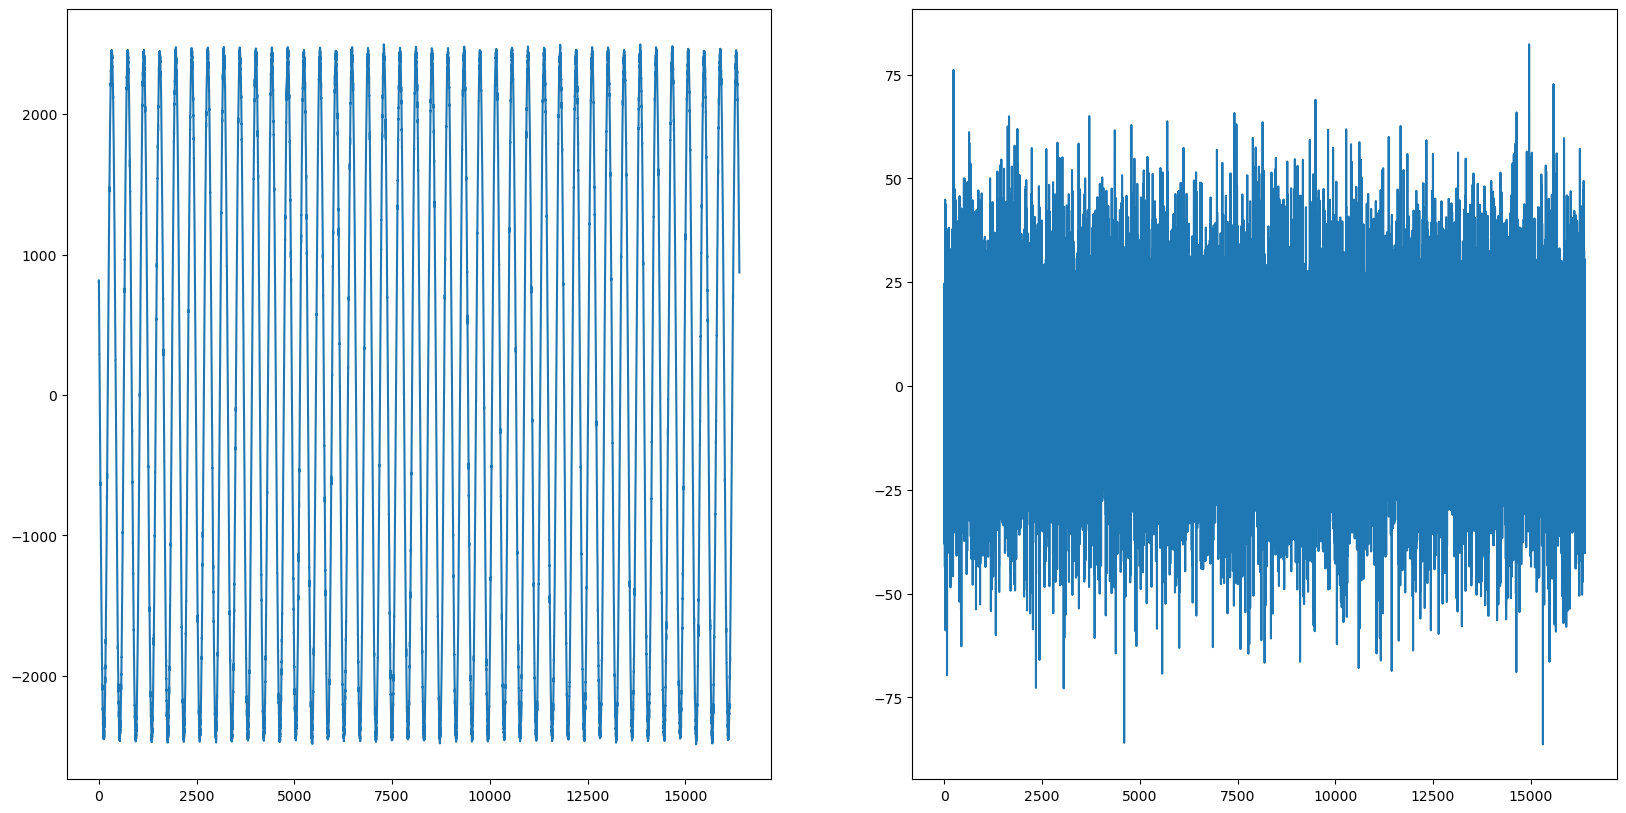

In [12]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[1].plot(noise_wf())
ax[0].plot(tone_wf())

## Waveform fitting

We will not fit the tone, but just guess what the fit output would be

In [13]:

Atone_fitted = Atone*V2ADC
# inferred  rms

V2ADC_fitted = Atone_fitted/Atone # in units ADC/V
var = noise_wf().var()
noise_level_inferred = np.sqrt(var/V2ADC_fitted**2/BW)
print ("Noise level inferred from waveform", noise_level_inferred, "vs true", noise_level)

Noise level inferred from waveform 3.498411931618291 vs true 3.5


## Power spectrum fitting


In [14]:
# the tone power spectrum
pfb = PFB()
pk_noise = pfb.get_pk(noise_wf)
pk_tone = pfb.get_pk(tone_wf)



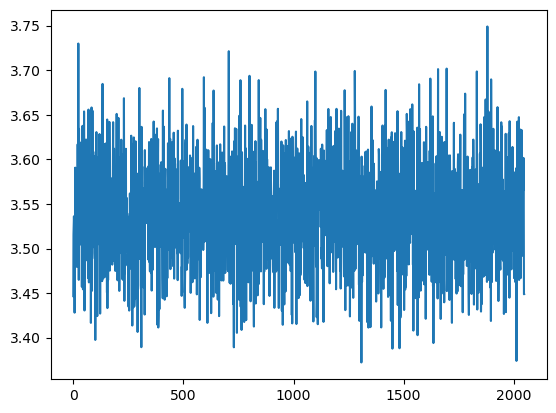

In [16]:
## note that Atone = App /2 
## power_in is how much powever in average we are putting into the single bin
bin_center_corr = 0.8773277205327629
power_in = Atone**2/2/binBW*bin_center_corr

V2power_inferred = (pk_tone[tonendx]-pk_noise[tonendx])/power_in
## the 0.87 is the correction coefficient
noise_power_sqrt_inferred = np.sqrt(pk_noise/V2power_inferred)
plt.plot(noise_power_sqrt_inferred)
noiseLevel_inferred_pk = np.sqrt((noise_power_sqrt_inferred**2)[1:].mean())


In [17]:
print ("Noise level inferred from the power spectrum:", noiseLevel_inferred_pk )

Noise level inferred from the power spectrum: 3.539471336466727
